# Linear Congruential Random Number Generators

>A **linear congruential generator** (**LCG**) is an algorithm that yields a sequence of pseudo-randomized numbers calculated with a discontinuous piecewise linear function. The method represents one of the oldest and best-known pseudorandom number generator algorithms. The theory behind them is relatively easy to understand, and they are easily implemented and fast, especially on computer hardware which can provide modular arithmetic by storage-bit truncation.
>
>The generator is defined by the recurrence relation:
>$$X_{n+1} = \left( a X_n + c \right)\bmod m$$
>where $X$ is the sequence of pseudo-random values, and
>- $m,\, 0\lt m$ is the "modulus",
>- $a,\,0 \lt a \lt  m$ is the "multiplier",
>- $c,\,0 \le c \lt  m$ is the "increment",
>- $X_0,\,0 \le X_0 \lt  m$ is the "seed" or "start value",
>These are integer constants that specify the generator.
>If $c=0$, the generator is often called a "multiplicative congruential generator" (MCG), or *Lehmer RNG*.
>If $c≠0$, the method is called a "mixed congruential generator".
>
>[[Wikipedia](https://en.wikipedia.org/wiki/Linear_congruential_generator)]

### Tasks

- Create an LCG with your Student ID as the modulus $m$, and suitable random values for $a, c$, and the *seed*. (See starter code below.)
- Use Decision Tress (DTs) from the `scikit-learn` library to assess the quality of your chosen PRNG. (If it is easy to predict the next digits then it is less random.)
    - Select 3 hyper-parameters and study their effect.

Explain your reasoning, and justify any choices of the hyperparameters (and/or run experiments to find the optimal ones).

Evaluate your models, and use visualisation to show the trees and any relevant plots.

Write a conclusion that summarises your findings, and makes recommendations.

In [32]:
from math import log
from random import randint
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import numpy as np
import warnings


## Initialisation of the LCG parameters

Assign suitable values to the fllowing variables.

In [33]:
#.#.#.#.#.#.# IMPORTANT #.#.#.#.#.#.#

MODULUS = 123456  # Set this to your Student ID

#.#.#.#.#.#.# IMPORTANT #.#.#.#.#.#.#

In [34]:
A = 101
C = 13
SEED = 321

### Base $b$ representation of numbers

In [35]:
def base_b(n, b):
    """ Get a list representing the number n written in base 'b' """
    bitlength = 1 + int(log(MODULUS) / log(b))
    r = []
    for _ in range(bitlength):
        r.insert(0, n % b)
        n //= b
    return r

# Example usage of base_b


In [36]:
print("Base 3 representation of 11:", base_b(11, 3)) # Example: 11 in base 3 is:   2+0*3+1*3^2   -->   102   -->   [0,0,...,1,0,2]

Base 3 representation of 11: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2]


## LCG

In [37]:
def lcg(seed, modulus, a, c):
    """ Linear congruential generator: X_{n+1} = (aX_n + c) mod m """
    while True:
        seed = (a * seed + c) % modulus
        yield seed

In [38]:
generator = lcg(SEED, MODULUS, A, C)

## Data generation

In [39]:
stream = [next(generator) for _ in range(10_000)]
print("First 10 numbers in the stream:", stream[:10])

First 10 numbers in the stream: [32434, 65991, 121936, 93405, 51262, 115779, 88828, 82809, 92170, 49983]


In [40]:
def get_features(stream, base):
    """ Replace each random number from 'stream' by a vector of its base b digits """
    return [base_b(n, base) for n in stream]


In [41]:
data = get_features(stream, base=3)


In [42]:
print("Example data point:", data[0])

Example data point: [0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1]


In [43]:
X = data[:-1]
y = data[1:]


In [44]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 7999
Testing set size: 2000


In [45]:
multi_clf = MultiOutputClassifier(tree.DecisionTreeClassifier(random_state=0))
multi_clf.fit(X_train, y_train)

y_pred_multi = multi_clf.predict(X_test)

In [46]:

def multioutput_accuracy(y_true, y_pred):
    """Calculate accuracy for multi-output predictions."""
    accuracies = [accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]
    return sum(accuracies) / len(accuracies)

def multioutput_metrics(y_true, y_pred):
    """Calculate various metrics for multi-output predictions."""
    metrics = {
        'accuracy': multioutput_accuracy(y_true, y_pred),
        'precision': np.mean([precision_score(y_true[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_true.shape[1])]),
        'recall': np.mean([recall_score(y_true[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_true.shape[1])]),
        'f1': np.mean([f1_score(y_true[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_true.shape[1])]),
    }
    return metrics


# Conclusion

........

In [47]:
y_test_array = np.array(y_test)
y_pred_multi_array = np.array(y_pred_multi)

metrics = multioutput_metrics(y_test_array, y_pred_multi_array)
print("Metrics (Multi-Output Decision Tree):", metrics)

Metrics (Multi-Output Decision Tree): {'accuracy': 0.5420454545454545, 'precision': np.float64(0.5327700417503418), 'recall': np.float64(0.5339696598825411), 'f1': np.float64(0.5332132317105143)}


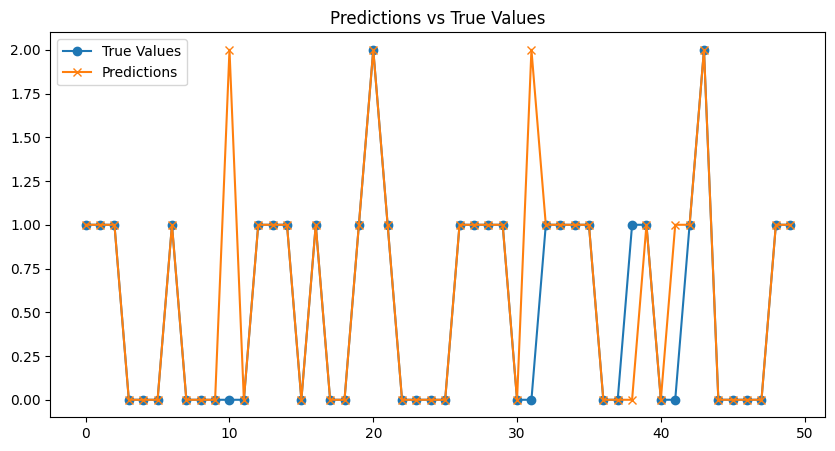

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_array[:50, 0], label='True Values', marker='o')  
plt.plot(y_pred_multi_array[:50, 0], label='Predictions', marker='x')
plt.legend()
plt.title("Predictions vs True Values")
plt.show()

In [ ]:
rf_multi_clf = MultiOutputClassifier(RandomForestClassifier(random_state=0, n_estimators=100))
rf_multi_clf.fit(X_train, y_train)

y_pred_rf_multi = rf_multi_clf.predict(X_test)
metrics_rf = multioutput_metrics(y_test_array, np.array(y_pred_rf_multi))
print("Metrics (Multi-Output Random Forest):", metrics_rf)

Metrics (Multi-Output Random Forest): {'accuracy': 0.5049545454545454, 'precision': np.float64(0.4810736239393373), 'recall': np.float64(0.48299702056052235), 'f1': np.float64(0.4814274798932209)}


In [50]:
gb_multi_clf = MultiOutputClassifier(GradientBoostingClassifier(random_state=0))
gb_multi_clf.fit(X_train, y_train)

# Make predictions with Gradient Boosting
y_pred_gb_multi = gb_multi_clf.predict(X_test)
metrics_gb = multioutput_metrics(y_test_array, np.array(y_pred_gb_multi))
print("Metrics (Gradient Boosting):", metrics_gb)




Metrics (Gradient Boosting): {'accuracy': 0.42386363636363633, 'precision': np.float64(0.4045806821630001), 'recall': np.float64(0.4056029101067129), 'f1': np.float64(0.4012649685872615)}
